In [1]:
import glob
import cobra
import cPickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
ijo = cobra.io.load_json_model('/home/sbrg-cjlloyd/Desktop/ecoli_M_models/iJO1366.json')
ile_value = ijo.reactions.BIOMASS_Ec_iJO1366_core_53p95M._metabolites[ijo.metabolites.ile__L_c]

In [23]:
def plot_growth_rate(files, exp_id):
    x = []
    y = []
    for sim in sorted(files):
        with open(sim) as f:
            sol = cPickle.load(f)
        if sol.x_dict['abundance_strain_0'] == .99 or sol.x_dict['abundance_strain_0'] < 0.02:
            print sol.x_dict['abundance_strain_0']
            continue
        x.append(sol.x_dict['abundance_strain_0'])
        y.append((abs(sol.x_dict['ILETA_strain_0'] +  sol.x_dict['ILETA_strain_1']))/ abs(ile_value))
    
    return x, y

In [24]:
def plot_ME_growth_rate(files, exp_id):
    x = []
    y = []
    for sim in sorted(files):
        with open(sim) as f:
            sol = cPickle.load(f)
        #print 1, sol.x_dict['dummy_reaction_FWD_SPONT_S1']
        #print 2, sol.x_dict['dummy_reaction_FWD_SPONT_S2']
        x.append(float(sim.split('/')[-1].split('_')[0]))
        y.append(sol.x_dict['biomass_dilution_S1'] + sol.x_dict['biomass_dilution_S2'])
    
    return x, y

In [25]:
def plot_metabolite_exchange(files, exp_id):
    x = []
    y = []
    exchange_fluxes = {}
    for r in ijo.reactions.query('EX_'):
        exchange_fluxes[r.id] = []
            
    for sim in sorted(files):
        with open(sim) as f:
            sol = cPickle.load(f)
        frac = sol.x_dict['abundance_strain_0']
        x.append(frac)
        for r, v in sol.x_dict.items():
            r = r.replace('_strain_1', '')
            if r not in ijo.reactions:
                continue     
            if ijo.reactions.get_by_id(r).lower_bound < 0:
                continue
            sol.x_dict[r] = v
        ijo.solution = sol
        
        for r in ijo.reactions.query('EX_'):
            if r.lower_bound < 0 or r.id=='EX_ac_e':
                continue
            exchange_fluxes[r.id].append(r.x)
        
    for r, flux in exchange_fluxes.items():
        flux = np.array(flux)
        if abs(flux).sum() <= 1e-2:
            exchange_fluxes.pop(r)
        else:
            pass
            #print r, flux.sum()
        
    return x, exchange_fluxes

In [131]:
def plot_ME_metabolite_exchange(files, exp_id, gr_norm=False):
    x = []
    grs = []
    exchange_fluxes = {}
    for r in ijo.reactions.query('EX_'):
        exchange_fluxes[r.id] = []
            
    for sim in sorted(files):
        with open(sim) as f:
            sol = cPickle.load(f)
        if sol is None:
            continue

        frac = (float(sim.split('/')[-1].split('_')[0]))
        x.append(frac)
        for r, v in sol.x_dict.items():
            r = r.replace('_S1', '').replace('_reverse', '')
            if r not in ijo.reactions:
                continue     
            if ijo.reactions.get_by_id(r).lower_bound < 0:
                continue
            sol.x_dict[r] = v
        ijo.solution = sol
        
        for r in ijo.reactions.query('EX_'):
            if r.lower_bound < 0 or r.id=='EX_ac_e':
                continue
            try:
                exchange_fluxes[r.id].append(r.x)
            except:
                continue
                print r
        
        grs.append(sol.x_dict['biomass_dilution_S1'] + sol.x_dict['biomass_dilution_S2'])
    
    for r, flux in exchange_fluxes.items():
        
        flux = np.array(flux)
        
        if len(flux) == 0:
            exchange_fluxes.pop(r)
            continue
        
        if abs(flux).sum() <= 1e-2:
            exchange_fluxes.pop(r)
            continue
        
        if gr_norm:
            flux = flux / np.array(grs)

    
        exchange_fluxes[r] = flux
        
    return x, exchange_fluxes

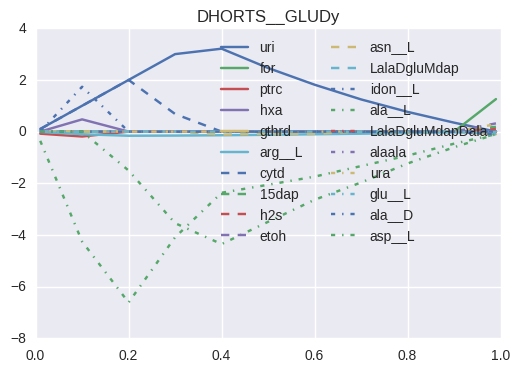

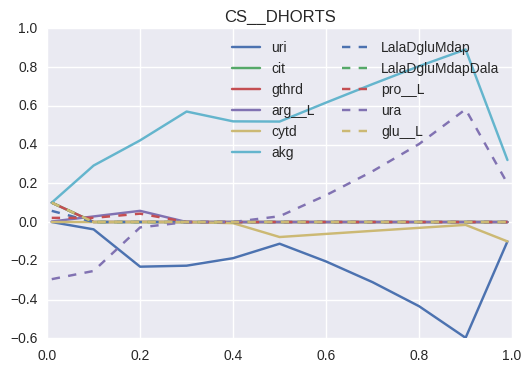

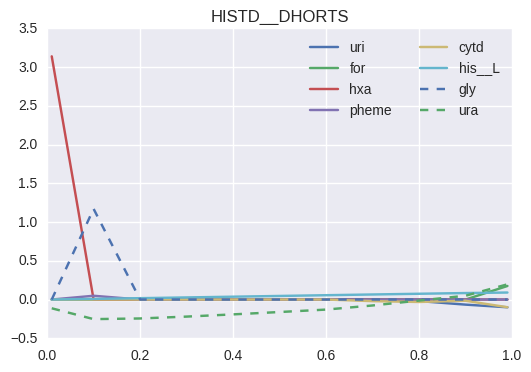

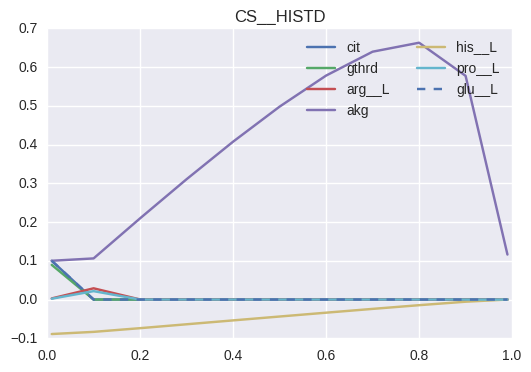

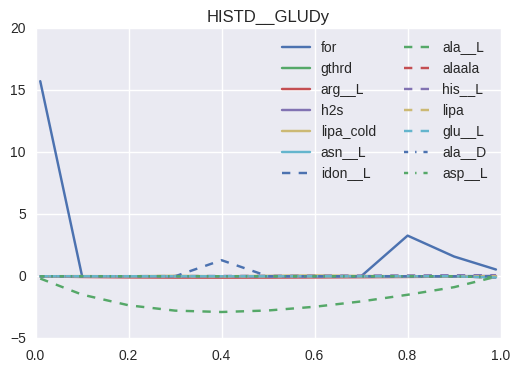

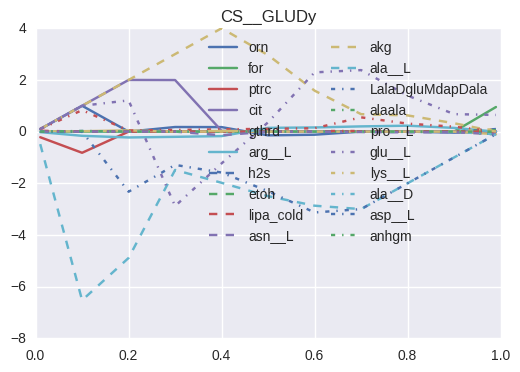

In [110]:
exp = ['DHORTS__GLUDy', 'CS__DHORTS', 'HISTD__DHORTS', 'CS__HISTD', 'HISTD__GLUDy', 'CS__GLUDy']
for ale in exp:
    i = 0
    plt.figure()
    x, ex =  plot_metabolite_exchange(glob.glob('./OptAux/M_community/%s/*' % ale), ale)
    plt.title(ale)
    for r, flux in ex.items():
        if i < 6:
            plt.plot(x, flux, label=r.replace('EX_','').replace('_e',''))
        elif i < 12:
            plt.plot(x, flux, '--', label=r.replace('EX_','').replace('_e',''))
        else:
            plt.plot(x, flux, '-.', label=r.replace('EX_','').replace('_e',''))
        i+=1
    plt.legend(ncol=2)

In [58]:
me.metabolites.orot_c_S1

{u'EX_his__L_e': array([ 0.03121936,  0.05788251,  0.07324584,  0.07995218,  0.07597692,
         0.06060848,  0.04179881,  0.02250214]),
 u'EX_ura_e': array([ 0.13745752,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ])}

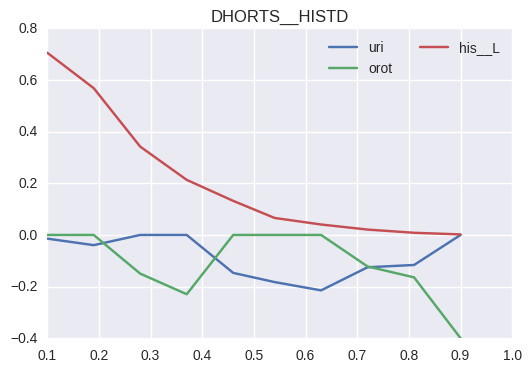

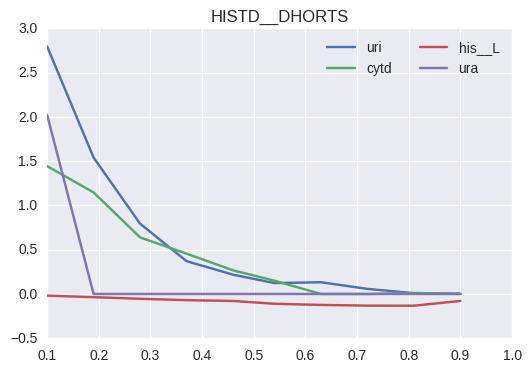

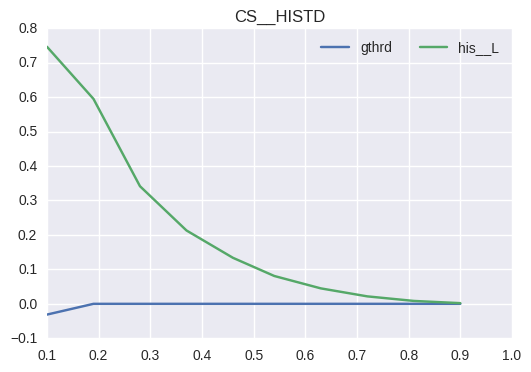

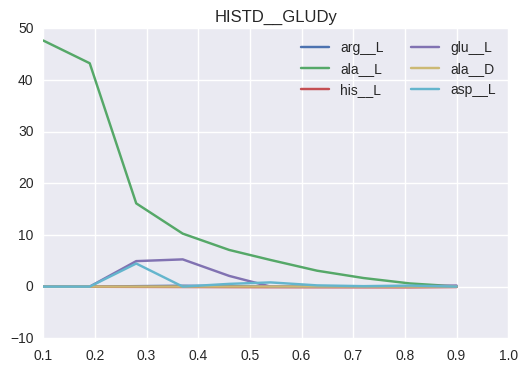

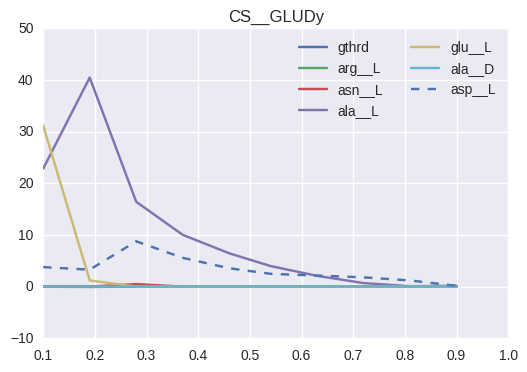

In [138]:
exp = ['DHORTS__HISTD', 'HISTD__DHORTS', 'CS__HISTD', 'HISTD__GLUDy', 'CS__GLUDy']
for ale in exp:
    i = 0
    plt.figure()
    x, ex =  plot_ME_metabolite_exchange(glob.glob('/home/sbrg-cjlloyd/Desktop/community_ME_scale_unmodeled_redo_secrete/%s/70_unmodeled_protein/*' % ale), ale)
    plt.title(ale)
    for r, flux in ex.items():
        if i < 6:
            plt.plot(x, flux, label=r.replace('EX_','').replace('_e',''))
        elif i < 12:
            plt.plot(x, flux, '--', label=r.replace('EX_','').replace('_e',''))
        else:
            plt.plot(x, flux, '-.', label=r.replace('EX_','').replace('_e',''))
        i+=1
    plt.legend(ncol=2)

0.01
0.99
0.01
0.99
0.01
0.99
0.01
0.99
0.01
0.99
0.01
0.99


(0.1, 0.9)

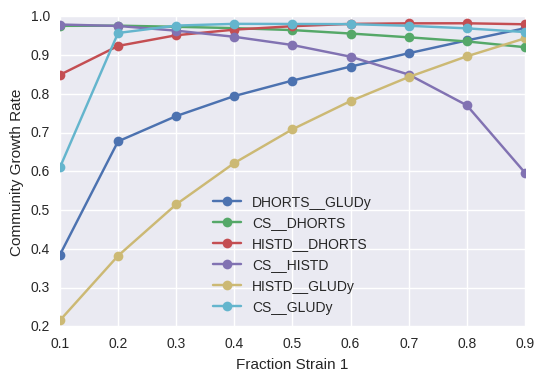

In [91]:
exp = ['DHORTS__GLUDy', 'CS__DHORTS', 'HISTD__DHORTS', 'CS__HISTD', 'HISTD__GLUDy', 'CS__GLUDy']
for ale in exp:
    #if 'HISTD' not in ale:
    #    continue
    x, y = plot_growth_rate(glob.glob('./OptAux/M_community/%s/*' % ale), ale)
    
    plt.plot(x, y, label=ale, marker='o')

plt.xlabel('Fraction Strain 1')
plt.ylabel('Community Growth Rate')
plt.legend(loc ='lower center')
plt.xlim([.1, .9])

In [21]:
[i.split('/')[-1] for i in glob.glob('../Desktop/community_ME_secrete/CS__GLUDy/*')]

['20_unmodled_protein',
 '40_unmodled_protein',
 '10_unmodled_protein',
 '80_unmodled_protein',
 '60_unmodled_protein']

[0.1, 0.19, 0.28, 0.37, 0.46, 0.54, 0.63, 0.72, 0.81, 0.9]
[0.1, 0.19, 0.28, 0.37, 0.46, 0.54, 0.63, 0.72, 0.81, 0.9]
[0.1, 0.19, 0.28, 0.37, 0.46, 0.54, 0.63, 0.72, 0.81, 0.9]
[0.1, 0.19, 0.28, 0.37, 0.46, 0.54, 0.63, 0.72, 0.81, 0.9]
[0.1, 0.19, 0.28, 0.37, 0.46, 0.54, 0.63, 0.72, 0.81, 0.9]
[0.1, 0.19, 0.28, 0.37, 0.46, 0.54, 0.63, 0.72, 0.81, 0.9]


(0.1, 0.9)

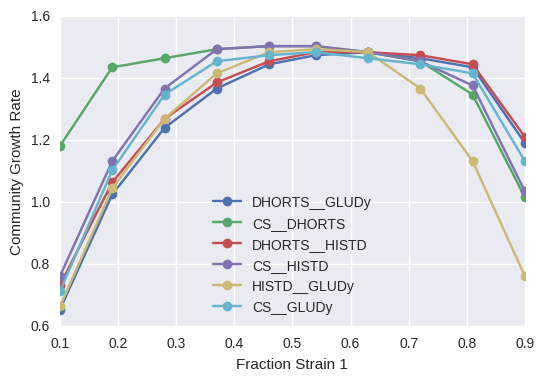

In [143]:
exp = ['DHORTS__GLUDy', 'CS__DHORTS', 'DHORTS__HISTD', 'CS__HISTD', 'HISTD__GLUDy', 'CS__GLUDy']
for ale in exp:
    x, y = plot_ME_growth_rate(glob.glob('/home/sbrg-cjlloyd/Desktop/community_ME_scale_unmodeled_redo_secrete/%s/90_unmodeled_protein/*' % ale), ale)
    print(x)
    plt.plot(x, y, label=ale, marker='o')

plt.xlabel('Fraction Strain 1')
plt.ylabel('Community Growth Rate')
plt.legend(loc ='lower center')
plt.xlim([.1, .9])

# Plots for lab meeting

0.01
0.99
0.01
0.99


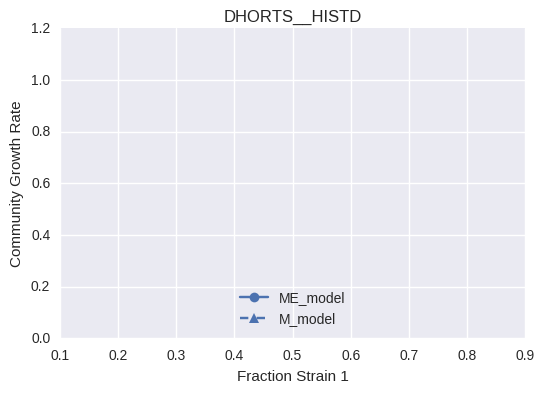

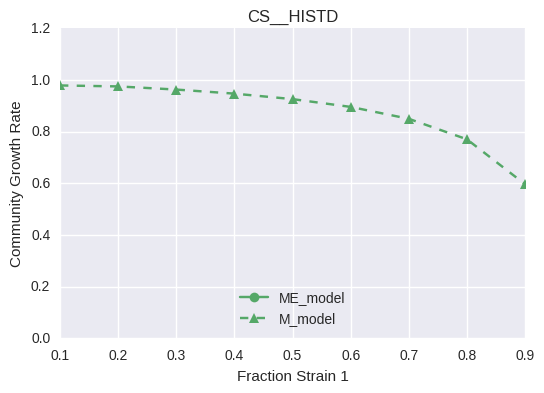

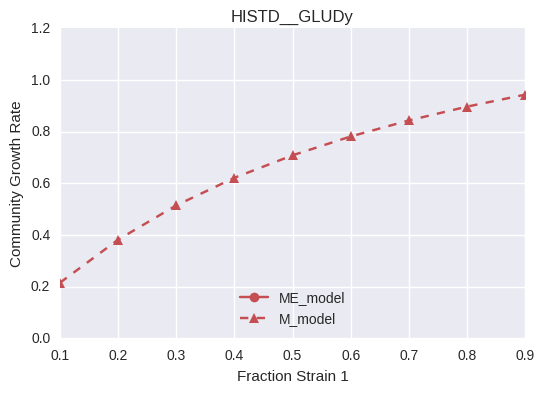

In [28]:
exp = ['DHORTS__HISTD', 'CS__HISTD', 'HISTD__GLUDy']
colors = sns.color_palette()
for i, ale in enumerate(exp):
    plt.figure()
    #if 'GLUDy' not in ale:
    #    continue
    x, y = plot_ME_growth_rate(glob.glob('/home/sbrg-cjlloyd/Desktop/community_ME_scale_unmodeled/%s/60_unmodeled_protein/*' % ale), ale)
    
    plt.plot(x, y, c = colors[i], label="ME_model", marker='o')
    
    x, y = plot_growth_rate(glob.glob('./OptAux/M_community/%s/*' % ale), ale)
    
    plt.plot(x, y,  '--', c= colors[i], label = 'M_model', marker='^')
    
    plt.xlabel('Fraction Strain 1')
    plt.ylabel('Community Growth Rate')
    plt.legend(loc ='lower center')
    plt.title(ale)
    plt.xlim([.1, .9])
    plt.ylim([0, 1.2])

## Normal

In [11]:
with open('./OptAux/ME_community/iLE1678_community.pickle') as f:
    me = cPickle.load(f)

In [26]:
plt.legend?

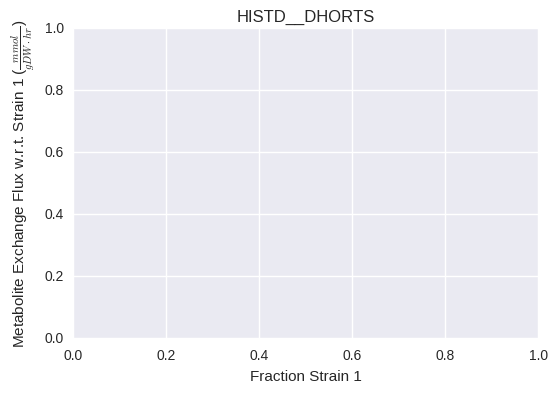

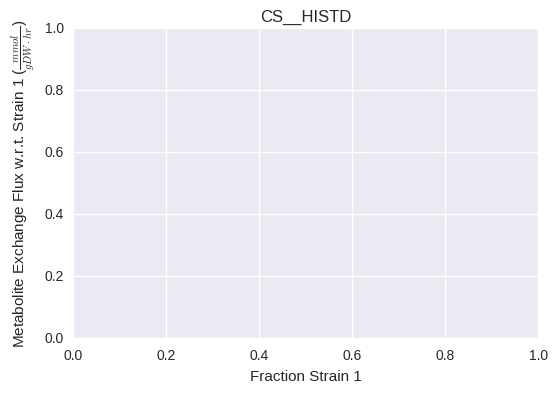

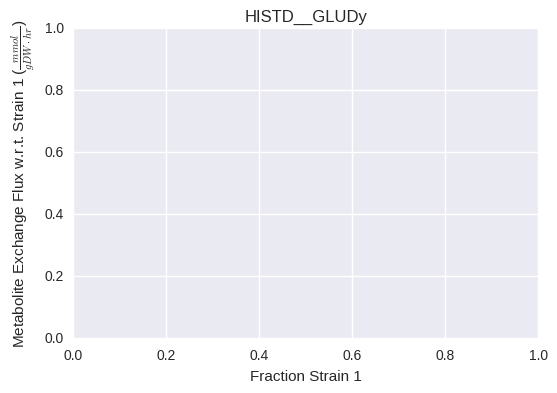

In [127]:
exp = ['HISTD__DHORTS', 'CS__HISTD', 'HISTD__GLUDy']
for ale in exp:
    i = 0
    plt.figure()
    x, ex =  plot_ME_metabolite_exchange(glob.glob('/home/sbrg-cjlloyd/Desktop/community_ME_scale_unmodeled/%s/60_unmodeled_protein/*' % ale), ale, gr_norm=False)
    plt.title(ale)
    for r, flux in ex.items():
        if i < 6:
            plt.plot(x, flux, label=r.replace('EX_','').replace('_e',''))
        elif i < 12:
            plt.plot(x, flux, '--', label=r.replace('EX_','').replace('_e',''))
        else:
            plt.plot(x, flux, '-.', label=r.replace('EX_','').replace('_e',''))
        i+=1
        
    plt.xlabel('Fraction Strain 1')
    plt.ylabel(r'Metabolite Exchange Flux w.r.t. Strain 1 ($\frac{mmol}{gDW \cdot hr}$)')
    plt.legend(bbox_to_anchor=(1.05, .5), ncol=2, frameon=True,fontsize=15, loc='center left')

## Normalize by growth rate

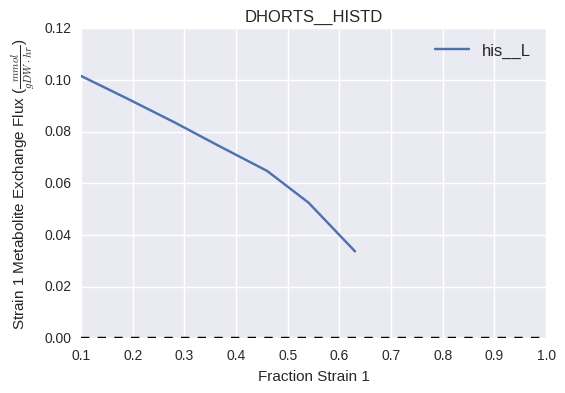

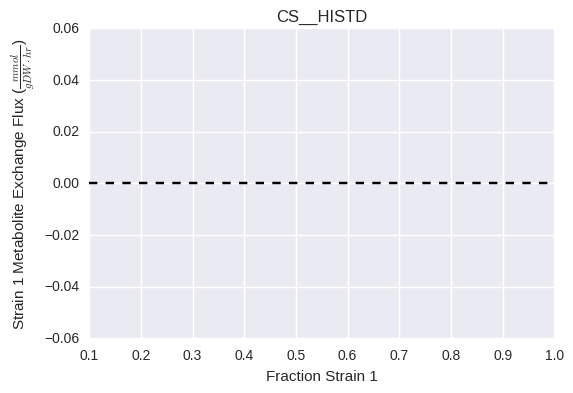

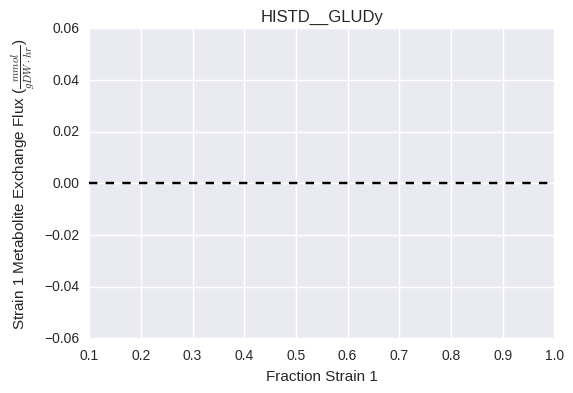

In [25]:
exp = ['DHORTS__HISTD', 'CS__HISTD', 'HISTD__GLUDy']
for ale in exp:
    i = 0
    plt.figure()
    x, ex =  plot_ME_metabolite_exchange(glob.glob('/home/sbrg-cjlloyd/Desktop/community_ME_scale_unmodeled/%s/60_unmodeled_protein/*' % ale), ale, gr_norm=True)
    plt.title(ale)
    for r, flux in ex.items():
        if i < 6:
            plt.plot(x, flux, label=r.replace('EX_','').replace('_e',''))
        elif i < 12:
            plt.plot(x, flux, '--', label=r.replace('EX_','').replace('_e',''))
        else:
            plt.plot(x, flux, '-.', label=r.replace('EX_','').replace('_e',''))
        i+=1
    plt.xlabel('Fraction Strain 1')
    plt.ylabel(r'Strain 1 Metabolite Exchange Flux ($\frac{mmol}{gDW \cdot hr}$)')
    plt.plot([.1,1], [0,0], 'k--')
    plt.legend(ncol=2, fontsize=12, loc='best')

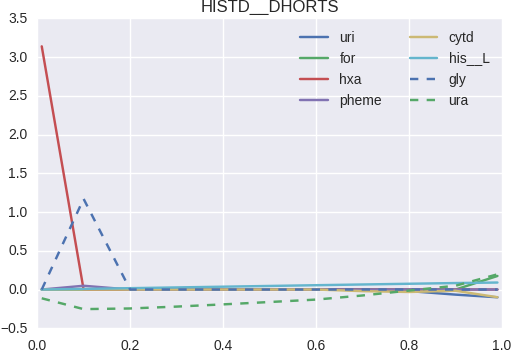

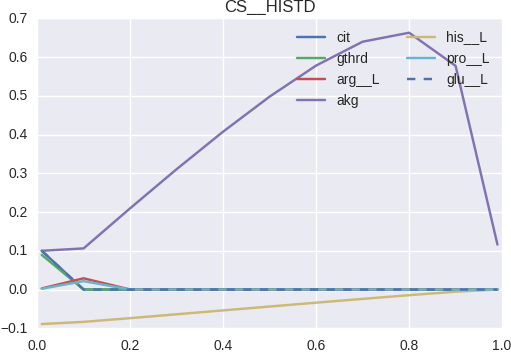

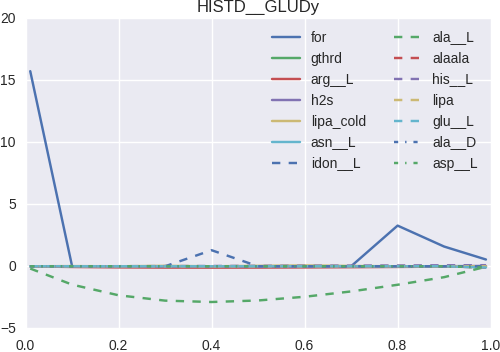

In [155]:
exp = ['HISTD__DHORTS', 'CS__HISTD', 'HISTD__GLUDy']
for ale in exp:
    i = 0
    plt.figure()
    x, ex =  plot_metabolite_exchange(glob.glob('./OptAux/M_community/%s/*' % ale), ale)
    plt.title(ale)
    for r, flux in ex.items():
        if i < 6:
            plt.plot(x, flux, label=r.replace('EX_','').replace('_e',''))
        elif i < 12:
            plt.plot(x, flux, '--', label=r.replace('EX_','').replace('_e',''))
        else:
            plt.plot(x, flux, '-.', label=r.replace('EX_','').replace('_e',''))
        i+=1
    plt.legend(ncol=2)

In [125]:
import cPickle
with open('/home/sbrg-cjlloyd/OptAux/OptAux/ME_community/iLE1678_community.pickle') as f:
    me = cPickle.load(f)

In [122]:
me.reactions.transcription_TU00161_from_RpoD_mono_S1.metabolites

{<Complex GreB_mono_S1 at 0x7f846c721350>: -4.27350427350427e-6*mu,
 <Complex GreA_mono_S1 at 0x7f846c721910>: -4.27350427350427e-6*mu,
 <Complex NusG_mono_S1 at 0x7f846c721bd0>: -4.27350427350427e-6*mu,
 <Complex NusA_mono_S1 at 0x7f846c721c50>: -4.27350427350427e-6*mu,
 <Complex Rho_hexa_mod_3:mg2_S1 at 0x7f846c721d50>: -4.27350427350427e-6*mu,
 <Complex Mfd_mono_mod_1:mg2_S1 at 0x7f846c721ed0>: -4.27350427350427e-6*mu,
 <Complex RpoZ_mono_mod_1:mg2_S1 at 0x7f846c721f90>: -4.27350427350427e-6*mu,
 <Constraint mRNA_biomass_S1 at 0x7f846ce79c50>: 1202.5832099999998,
 <Metabolite h_c_S1 at 0x7f846c721150>: 3,
 <Metabolite ppi_c_S1 at 0x7f846c721290>: 3879,
 <Metabolite pi_c_S1 at 0x7f846c721310>: 3,
 <Metabolite adp_c_S1 at 0x7f846c721590>: 3,
 <Metabolite gtp_c_S1 at 0x7f846c721690>: -949,
 <Metabolite atp_c_S1 at 0x7f846c721750>: -888,
 <Metabolite utp_c_S1 at 0x7f846c7217d0>: -867,
 <Metabolite h2o_c_S1 at 0x7f846c721b50>: -3,
 <Metabolite ctp_c_S1 at 0x7f846c721f10>: -1178,
 <RNAP R

In [121]:
me.reactions.transcription_TU00161_from_RpoD_mono_S2.metabolites

{<Complex NusG_mono_S2 at 0x7f84655c25d0>: -4.27350427350427e-6*mu,
 <Complex RpoZ_mono_mod_1:mg2_S2 at 0x7f84655c26d0>: -4.27350427350427e-6*mu,
 <Complex Mfd_mono_mod_1:mg2_S2 at 0x7f84655c2750>: -4.27350427350427e-6*mu,
 <Complex NusA_mono_S2 at 0x7f84655c27d0>: -4.27350427350427e-6*mu,
 <Complex GreB_mono_S2 at 0x7f84655c2890>: -4.27350427350427e-6*mu,
 <Complex GreA_mono_S2 at 0x7f84655c2950>: -4.27350427350427e-6*mu,
 <Complex Rho_hexa_mod_3:mg2_S2 at 0x7f84655c2990>: -4.27350427350427e-6*mu,
 <Constraint mRNA_biomass_S2 at 0x7f846569ba50>: 1202.5832099999998,
 <Metabolite gtp_c_S2 at 0x7f84655c24d0>: -949,
 <Metabolite pi_c_S2 at 0x7f84655c2510>: 3,
 <Metabolite ctp_c_S2 at 0x7f84655c2550>: -1178,
 <Metabolite atp_c_S2 at 0x7f84655c2590>: -888,
 <Metabolite h_c_S2 at 0x7f84655c2610>: 3,
 <Metabolite utp_c_S2 at 0x7f84655c2650>: -867,
 <Metabolite adp_c_S2 at 0x7f84655c2690>: 3,
 <Metabolite h2o_c_S2 at 0x7f84655c2810>: -3,
 <Metabolite ppi_c_S2 at 0x7f84655c2850>: 3879,
 <RNAP R

In [96]:
with open('/home/sbrg-cjlloyd/Desktop/community_ME_scale_unmodeled_redo_secrete/DHORTS__HISTD/100_unmodeled_protein/0.10_frac_strain1.pickle') as f:
    sol = cPickle.load(f)

In [66]:
with open('/home/sbrg-cjlloyd/OptAux/OptAux/ME_community/iLE1678.pickle') as f:
    me = cPickle.load(f)

In [70]:
me.stoichiometric_data.GAPD

<StoichiometricData GAPD_S1 at 0x7f846a384590>

In [ ]:
for d in me.stoichiometric_data:
    d.id = d.id+ '_S1'
for r in me.reactions:
    r.id = r.id+ '_S1'
me.repair()

In [88]:
import escher




view = escher.Builder("iJO1366.Central metabolism")
view.reaction_data ={i.replace('_S1',''): v for i, v in me.get_metabolic_flux(solution=e).items()}
view.display_in_notebook()

In [80]:
sol.x_dict['biomass_dilution_S1']

0.45768229166666641

In [115]:
import pickle
for f in sorted(glob.glob('/home/sbrg-cjlloyd/Desktop/community_ME_scale_unmodeled_redo_secrete/DHORTS__HISTD/100_unmodeled_protein/*')):
    with open(f, 'rb') as f:
        sol = pickle.load(f)
    if sol is None:
        continue
    else:
        e = sol
    print(sol.x_dict['biomass_dilution_S1'], sol.x_dict['EX_glc__D_e_S2'])


(0.1272786458333334, -6.7639418855694728)
(0.26855468750000022, -8.4801126099776312)
(0.41894531250000033, -8.7242732492335389)
(0.57389322916666718, -8.3987619805429841)
(0.72309027777777846, -7.806601392681821)
(0.79785156249999956, -5.8191719457553734)
(0.78287760416666641, -4.1611520483367803)
(0.63368055555555547, -2.3457818558522283)


In [47]:
with open( '/home/sbrg-cjlloyd/Desktop/community_ME_scale_unmodeled/DHORTS__HISTD/100_unmodeled_protein/0.37_frac_strain1.pickle') as f:
    sol = cPickle.load(f)

In [111]:
print e.x_dict['EX_glc__D_e_S1'], e.x_dict['EX_glc__D_e_S2']

-4.75895282323 -9.19979214637


In [113]:
for k, v in e.x_dict.items():
    if 'EX_' in k and abs(v) > 1e-6 and 'Shared' not in k:
        print(k, v)

(u'EX_his__L_e_S1', 0.10863048789549133)
(u'EX_so4_e_S1', -0.1026952053550985)
(u'EX_so4_e_S2', -0.11971343546388967)
(u'EX_ac_e_S2', 0.31504474456032244)
(u'EX_ac_e_S1', 0.25666555010242909)
(u'EX_h2o_e_S1', 22.690814869074398)
(u'EX_h2o_e_S2', 35.958307667306237)
(u'EX_his__L_e_S2_reverse', -0.062891335097389728)
(u'EX_pi_e_S1', -0.55423561903812468)
(u'EX_pi_e_S2', -1.1008445614636131)
(u'EX_mn2_e_S1', -3.5592078379002603e-05)
(u'EX_mn2_e_S2', -4.8658855662474232e-05)
(u'EX_cytd_e_S1_reverse', -0.13680717623907107)
(u'EX_o2_e_S2', -9.9601112662262885)
(u'EX_o2_e_S1', -7.2446604992635457)
(u'EX_fe2_e_S2', -0.00031805607230326254)
(u'EX_fe2_e_S1', -0.00012920775517019376)
(u'EX_cobalt2_e_S1', -9.2557165348842425e-06)
(u'EX_cobalt2_e_S2', -0.00010213545961212974)
('EX_C10H8O5_c_S1', 3.4134013457128677e-05)
('EX_C10H8O5_c_S2', 5.8493644217157908e-05)
(u'EX_uri_e_S2', 0.068435919193058609)
(u'EX_h_e_S1', 3.7333618747942268)
(u'EX_h_e_S2', 5.5550515250050863)
(u'EX_nh4_e_S1', -5.003289066

In [45]:
me.reactions.EX_his__L_e_S1

1.0546875

In [46]:
sol.x_dict['biomass_dilution_S2']

0.1171875